Input Libraries

In [128]:
!pip install numpy

In [129]:
!pip install matplotlib

In [130]:
!pip install tensorflow

In [131]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to c:\users\hp\appdata\local\temp\pip-req-build-53vr67ux
  Resolved https://github.com/tensorflow/docs to commit 1054aa3c4bc8379799fe84b32f5b8ef31ddfa61f
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\HP\AppData\Local\Temp\pip-req-build-53vr67ux'


In [132]:
!pip install ipython

In [136]:
# Required to save models in HDF5 format
!pip install pyyaml h5py  

In [40]:
import numpy as np
import os
import PIL
import PIL.Image
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import pathlib
import shutil
import tempfile
from IPython import display

In [2]:
'''
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors = True)
'''

In [41]:
print(os.getcwd())
os.chdir('D:\Load_Sample')
print(os.getcwd())
class_names=os.listdir() 
num_class= len(class_names)
print(class_names)
print(num_class)

D:\Load_Sample
D:\Load_Sample
['Perfecto', 'Salopette', 'Trench']
3


In [42]:
img_height=128
img_width=128

# Build Input Pipeline
## Tensorflow Training dataset

In [43]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.getcwd(),
    labels='inferred',
    label_mode='int',
    class_names= class_names,
    color_mode='grayscale',
    batch_size=128,
    image_size=(img_width,img_width),
    shuffle=True,
    seed=20,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 1312 files belonging to 3 classes.
Using 1050 files for training.


In [44]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [45]:
for ima, lab in train_ds.take(1):
    for x in lab:
        print(x.numpy())

0
1
0
2
2
2
0
2
0
2
0
0
0
0
1
2
2
0
1
0
2
0
2
2
0
0
2
0
2
2
2
0
0
2
0
0
2
2
1
1
1
1
0
0
2
2
0
2
0
0
2
0
2
2
0
0
0
0
1
2
0
2
2
0
2
0
2
0
2
1
0
2
0
0
0
0
2
0
0
0
1
2
2
0
0
1
1
0
0
0
0
0
2
0
0
0
0
0
0
1
2
0
1
0
0
0
0
0
0
1
0
2
2
2
2
0
0
0
0
2
0
2
0
2
2
2
0
0


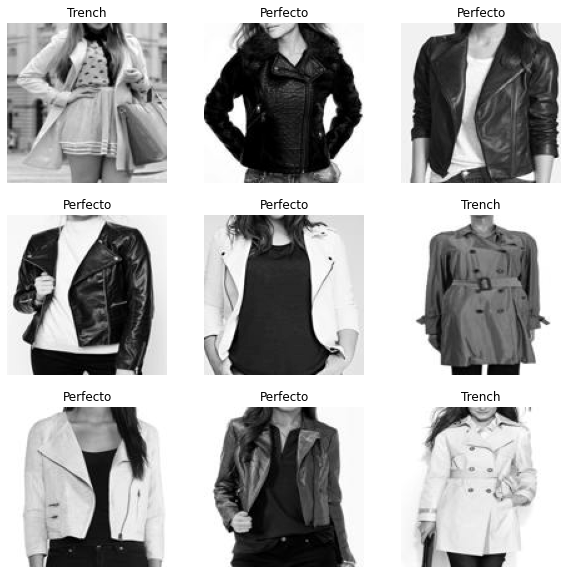

In [46]:
plt.figure(figsize=(10,10))
for image, label in train_ds.take(1):
    for x in range(9):
        ax=plt.subplot(3, 3, x+1)
        plt.imshow(image[x].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[label[x].numpy()])
        plt.axis("off")
plt.show()

## Tensorflow Validation dataset

In [47]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
    os.getcwd(),
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    color_mode='grayscale',
    batch_size=128,
    image_size=(img_height,img_width),
    shuffle=True,
    seed=20,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 1312 files belonging to 3 classes.
Using 262 files for validation.


In [48]:
validation_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

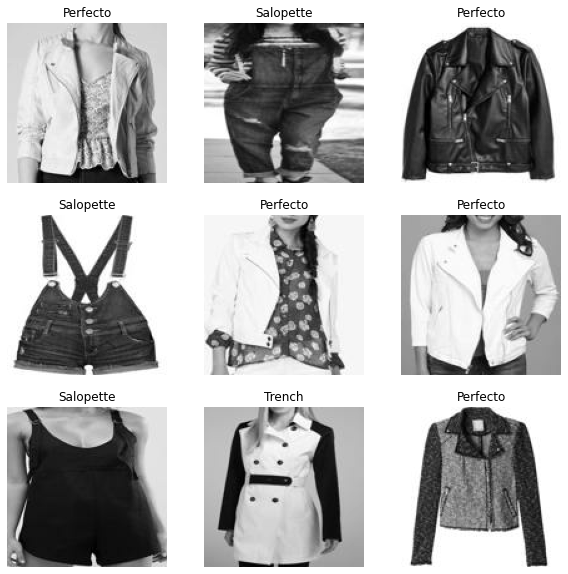

In [49]:
plt.figure(figsize=(10,10))
for image, label in validation_ds.take(1):
    for x in range(9):
        ax=plt.subplot(3, 3, x+1)
        plt.imshow(image[x].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[label[x].numpy()])
        plt.axis("off")
plt.show()

## Configure the dataset for performance

In [50]:
AUTOTUNE=tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data Augumentation

In [51]:
data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip(input_shape=(img_height, img_width, 1)),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
])

In [53]:

def get_callbacks():
    #Save checkpoints during training
    #checkpoint_path = "ModelOutput/training_1/cp.ckpt"
    #checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    #cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
    #                                             save_weights_only=True,
    #                                             verbose=1)
    return [
    #tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    #tf.keras.callbacks.TensorBoard(logdir/name),
    #cp_callback 
    ]


# Build the Model
## Set up the Model Layers

In [62]:
model = tf.keras.Sequential([
          data_augmentation,
          tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
          tf.keras.layers.Conv2D(32, 3, activation='relu'),
          tf.keras.layers.MaxPooling2D(),
          tf.keras.layers.Conv2D(32, 3, activation='relu'),
          tf.keras.layers.MaxPooling2D(),
          tf.keras.layers.Conv2D(32, 3, activation='relu'),
          tf.keras.layers.MaxPooling2D(),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
          #tf.keras.layers.Dropout(0.2),
          #tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
          #tf.keras.layers.Dropout(0.2),
          #tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dense(num_class, activation='softmax')
          ])

In [63]:
# Display the model's architecture

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 128, 128, 1)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 128, 128, 1)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                 

In [64]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [65]:
epochs=1000
history = model.fit(train_ds, validation_data = validation_ds, epochs=epochs, callbacks=get_callbacks())

Epoch 1/1000
9/9 [==============================] - 8s 745ms/step - loss: 0.9464 - accuracy: 0.5552 - val_loss: 0.9174 - val_accuracy: 0.6260
Epoch 2/1000
9/9 [==============================] - 6s 702ms/step - loss: 0.8388 - accuracy: 0.6695 - val_loss: 0.9376 - val_accuracy: 0.6107
Epoch 3/1000
9/9 [==============================] - 7s 805ms/step - loss: 0.7988 - accuracy: 0.6810 - val_loss: 0.8128 - val_accuracy: 0.6374
Epoch 4/1000
9/9 [==============================] - 8s 855ms/step - loss: 0.7527 - accuracy: 0.6867 - val_loss: 0.7686 - val_accuracy: 0.6603
Epoch 5/1000
9/9 [==============================] - 8s 883ms/step - loss: 0.7142 - accuracy: 0.7029 - val_loss: 0.7531 - val_accuracy: 0.6527
Epoch 6/1000
9/9 [==============================] - 8s 899ms/step - loss: 0.6923 - accuracy: 0.7219 - val_loss: 0.7123 - val_accuracy: 0.6679
Epoch 7/1000
9/9 [==============================] - 9s 975ms/step - loss: 0.6798 - accuracy: 0.7429 - val_loss: 0.6967 - val_accuracy: 0.6985
Epoch 

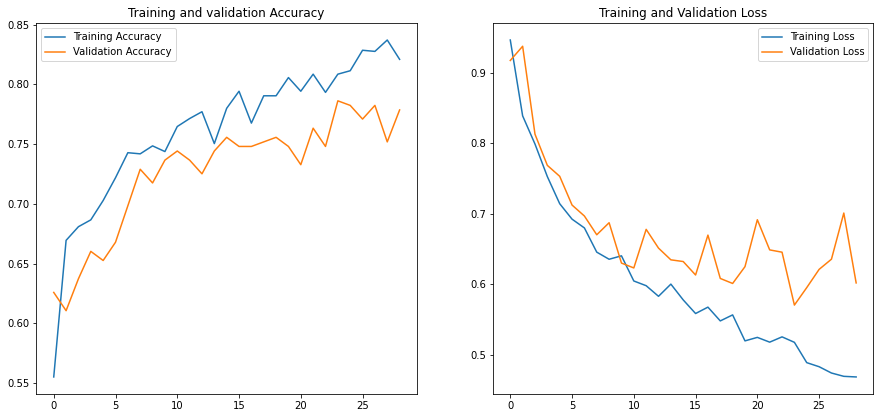

In [66]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss'] 
val_loss = history.history['val_loss']
#epochs_range = range(epochs)
epochs_range = range(len(val_acc))
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_acc, label= 'Training Accuracy')
plt.plot(epochs_range, val_acc, label= 'Validation Accuracy')
#loc='lower right'
plt.legend()
plt.title('Training and validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
#loc='Upper right'
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [37]:
best_epoch= val_acc.index(max(val_acc))+1
best_epoch

5

In [25]:
#Manually save weights
# Save the weights
model.save_weights('D:\ModelOutputs\checkpoints\my_checkpoint')


In [26]:
model.save('D:\ModelOutputs\saved_model\my_model')


INFO:tensorflow:Assets written to: D:\ModelOutputs\saved_model\my_model\assets


INFO:tensorflow:Assets written to: D:\ModelOutputs\saved_model\my_model\assets


In [39]:
'''
plotter = tfdocs.plots.HistoryPlotter(metric='sparse_categorical_crossentropy', smoothing_std=10)
plotter.plot(history.history)
plt.ylim([0.5, 0.7])
'''

AttributeError: 'list' object has no attribute 'history'